In [229]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
#import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn import svm, linear_model

In [200]:
data = pd.read_csv("weather_data/weather_prediction_dataset.csv")
towns = {col.split("_")[0] for col in data.columns[2:]}
m = [min([i if c.lower() == c else 10 for i, c in enumerate(col.split("_"))]) for col in data.columns]
towns = {"_".join(col.split("_")[:m[i]]) for i, col in enumerate(data.columns)}
towns.remove("DATE")
towns.remove("MONTH")
towns.remove("ROMA")
towns.remove("MALMO")
labels = pd.read_csv("weather_data/weather_prediction_picnic_labels.csv").replace({True: 1, False: 0})
data = data.join(labels.set_index("DATE"), on="DATE")

In [201]:
all_combined = None
town_data = {}
cols = {}
full_towns = set()
print(f"{'TOWN':10} is full")
for t in towns:
    temp = data.loc[:, data.columns.str.startswith(t)]
    temp.columns = [col.strip(t+"_") for col in temp.columns]
    town_data[t] = temp
    if len(temp.columns) == 12:
        full_towns.add(t)
        print(f"{t:12} YES")
        print(temp.columns)
        print()
        if all_combined is None:
            all_combined = temp
            cols = temp.columns
        else:
            all_combined = pd.concat([all_combined, temp])
            cols = cols.intersection(temp.columns)
    else:
        print(f"{t:12} NO")
        print(temp.columns)
        print()
all_full_combined = all_combined.reset_index().drop("index", axis=1)

TOWN       is full
DE_BILT      YES
Index(['cloud_cover', 'wind_speed', 'wind_gust', 'humidity', 'pressure',
       'global_radiation', 'precipitation', 'sunshine', 'temp_mean',
       'temp_min', 'temp_max', 'picnic_weather'],
      dtype='object')

TOURS        NO
Index(['wind_speed', 'humidity', 'pressure', 'global_radiation',
       'precipitation', 'temp_mean', 'temp_min', 'temp_max', 'picnic_weather'],
      dtype='object')

LJUBLJANA    NO
Index(['cloud_cover', 'wind_speed', 'humidity', 'pressure', 'global_radiation',
       'precipitation', 'sunshine', 'temp_mean', 'temp_min', 'temp_max',
       'picnic_weather'],
      dtype='object')

MAASTRICHT   YES
Index(['cloud_cover', 'wind_speed', 'wind_gust', 'humidity', 'pressure',
       'global_radiation', 'precipitation', 'sunshine', 'temp_mean',
       'temp_min', 'temp_max', 'picnic_weather'],
      dtype='object')

MUENCHEN     YES
Index(['cloud_cover', 'wind_speed', 'wind_gust', 'humidity', 'pressure',
       'global_radiation'

In [287]:
def get_town_data(data_split, town, seed):
    # Load and shuffle
    tow = town_data[town]
    tow = shuffle(tow,random_state=seed)
    
    n = tow.shape[0]
    k = sum(data_split)
    train_stop = int(n*data_split[0]/k)
    test_stop = train_stop+int(n*data_split[1]/k)
    
    # Split data and label
    data = tow.loc[:, tow.columns[:-1]]
    labels = tow.loc[:, tow.columns[-1]]

    # Split train and test
    train_data = data.iloc[:train_stop, :]
    test_data = data.iloc[train_stop:test_stop, :]
    valid_data = data.iloc[test_stop:, :]
    train_labels = labels.iloc[:train_stop]
    test_labels = labels.iloc[train_stop:test_stop]
    valid_labels = labels.iloc[test_stop:]

    # Normalize
    means = train_data.mean(axis=0)
    var = train_data.var(axis=0)
    train_data = (train_data-means)/(var**0.5)
    test_data = (test_data-means)/(var**0.5)
    valid_data = (valid_data-means)/(var**0.5)

    return train_data, train_labels, test_data, test_labels, valid_data, valid_labels, means, var

In [176]:
def get_multiple_town_data(train_size, towns, seed, testing):
    # Load and shuffle
    tow = None
    for  t in towns:
        temp = town_data[t]
        if tow is None:
            tow = temp
        else:
            tow = pd.concat([tow, temp])
            
    tow = shuffle(tow,random_state=seed)
    
    # Split data and label
    data = tow.loc[:, tow.columns[:-1]]
    labels = tow.loc[:, tow.columns[-1]]

    if testing:
        # Split train and test
        train_data = data.iloc[:train_size, :]
        test_data = data.iloc[train_size:, :]
        train_labels = labels.iloc[:train_size]
        test_labels = labels.iloc[train_size:]

        # Normalize
        means = train_data.mean(axis=0)
        var = train_data.var(axis=0)
        train_data = (train_data-means)/(var**0.5)
        test_data = (test_data-means)/(var**0.5)

        return train_data, train_labels, test_data, test_labels, means, var
    else:
        # Normalize
        means = data.mean(axis=0)
        var = data.var(axis=0)
        data = (data-means)/(var**0.5)

        return data, labels, means, var

BASEL test

In [286]:
va_l

0

In [288]:
tr_d, tr_l, te_d, te_l, va_d, va_l, m, v = get_town_data([8,1,1], "BASEL", 42)

In [289]:
val = 11
step = 4
way = 1
best_score = 0
best_val = val
tested = False

while step > 0.02:
    svc = svm.SVC(C=val, kernel='rbf', random_state=42)
    svc.fit(tr_d, tr_l)
    cross_score = np.mean(cross_val_score(svc, te_d, te_l, cv=5))
    if cross_score > best_score:
        best_score = cross_score
        best_val = val 
        tested = False
    elif not tested:
        way *= -1
        #step /= 2
        tested = True
    else:
        step /= 2
        tested = False
    #print(val, cross_score)
    val += step*way
    

print(best_val, best_score)

23 0.8931506849315067


In [290]:
val = 11
step = 4
way = 1
best_score = 0
best_val = val
tested = False

while step > 0.02:
    lin_svc = svm.LinearSVC(C=val, dual="auto", random_state=42)
    lin_svc.fit(tr_d, tr_l)
    cross_score = np.mean(cross_val_score(lin_svc, te_d, te_l, cv=5))
    if cross_score > best_score:
        best_score = cross_score
        best_val = val 
        tested = False
    elif not tested:
        way *= -1
        #step /= 2
        tested = True
    else:
        step /= 2
        tested = False
    #print(val, cross_score)
    val += step*way
    

print(best_val, best_score)

23 0.9424657534246575


In [293]:
val = 1
step = 0.8
way = 1
best_score = 0
best_val = val
tested = False

while step > 0.00002:
    svc_with_sgd = linear_model.SGDClassifier(alpha=val, random_state=42, loss="hinge")
    svc_with_sgd.fit(tr_d, tr_l)
    cross_score = np.mean(cross_val_score(svc_with_sgd, te_d, te_l, cv=5))
    if cross_score > best_score:
        best_score = cross_score
        best_val = val 
        tested = False
    elif not tested:
        way *= -1
        #step /= 2
        tested = True
    else:
        step /= 2
        tested = False
    #print(val, cross_score)
    val = max(0.00000001, val+step*way)
    

print(best_val, best_score)

1e-08 0.8931506849315068


In [292]:
cross_score = np.mean(cross_val_score(svc, va_d, va_l, cv=5))
print(f"SVC RBF: {cross_score}")
cross_score = np.mean(cross_val_score(lin_svc, va_d, va_l, cv=5))
print(f"SVC Lin: {cross_score}")
cross_score = np.mean(cross_val_score(svc_with_sgd, va_d, va_l, cv=5))
print(f"SVC SGD: {cross_score}")

SVC RBF: 0.9263235838578303
SVC Lin: 0.9536097741577194
SVC SGD: 0.8880414661236579


In [203]:
clf = RandomForestClassifier(max_depth=5, random_state=0)
clf.fit(tr_d, tr_l)

RandomForestClassifier(max_depth=5, random_state=0)

In [204]:
crossScore = np.mean(cross_val_score(clf, te_d, te_l, cv=5))
crossScore

0.9915090543259557

Simple NN vs Tranfer learning

In [227]:
ft = full_towns.copy()
tt = ft.pop()

print(f"TEST TOWN: {tt}")

main_tr_d, main_tr_l, _, _ = get_multiple_town_data(0, ft, 42, False)

spe_tr_d, spe_tr_l, spe_te_d, spe_te_l, _, _, _, _ = get_town_data([9,1,0], tt, 42)

TEST TOWN: MAASTRICHT


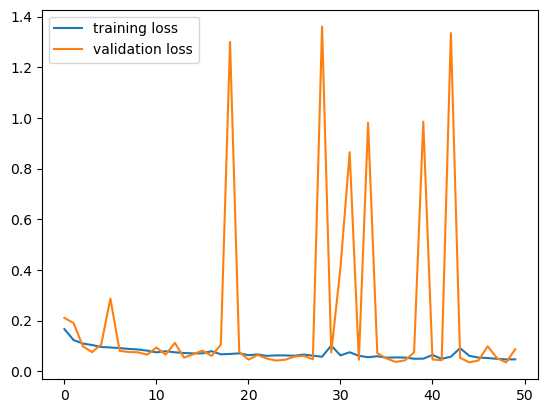

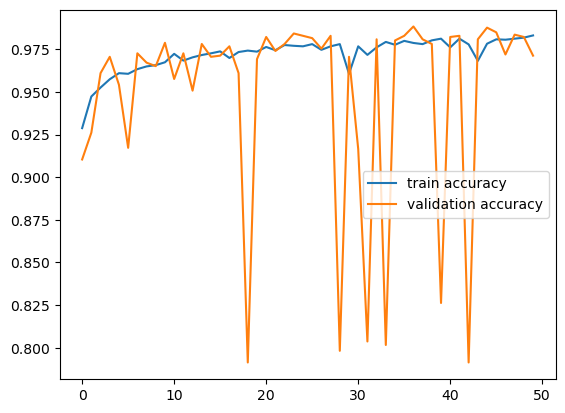

12/12 [==============================] - 0s 2ms/step - loss: 0.0592 - accuracy: 0.9808


loss: 0.05922138690948486 | train acc: 0.9808219075202942
12/12 [==============================] - 0s 1ms/step - loss: 0.0592 - accuracy: 0.9808


Before transfering: loss: 0.05922138690948486 | train acc: 0.9808219075202942



In [316]:
mlp_for_transfer = Sequential()
mlp_for_transfer.add(Dense(24, activation='tanh', input_dim=main_tr_d.shape[1]))
mlp_for_transfer.add(Dense(8, activation='tanh', input_dim=main_tr_d.shape[1]))
mlp_for_transfer.add(Dense(12, activation='tanh', input_dim=main_tr_d.shape[1]))
mlp_for_transfer.add(Dense(2, activation='softmax'))

mlp_for_transfer.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=0.4),  metrics=['accuracy'])

history_for_transfer = mlp_for_transfer.fit(main_tr_d, keras.utils.to_categorical(main_tr_l), epochs=50, validation_split=0.1, verbose=False)

plt.figure()
plt.plot(history_for_transfer.history['loss'], label='training loss')
plt.plot(history_for_transfer.history['val_loss'], label='validation loss')
plt.legend(loc='best')

plt.figure()
plt.plot(history_for_transfer.history['accuracy'], label='train accuracy')
plt.plot(history_for_transfer.history['val_accuracy'], label='validation accuracy')
plt.legend(loc='best')
plt.show()

score = mlp_for_transfer.evaluate(spe_te_d, keras.utils.to_categorical(spe_te_l))
print("\n\nloss: {} | train acc: {}".format(score[0], score[1]))

for i in range(len(mlp_for_transfer.layers)-1):
    mlp_for_transfer.layers[i].trainable = False
    
score = mlp_for_transfer.evaluate(spe_te_d, keras.utils.to_categorical(spe_te_l))
print("\n\nBefore transfering: loss: {} | train acc: {}\n".format(score[0], score[1]))

12/12 [==============================] - 0s 2ms/step - loss: 0.0985 - accuracy: 0.9616


loss: 0.09845352172851562 | train acc: 0.9616438150405884


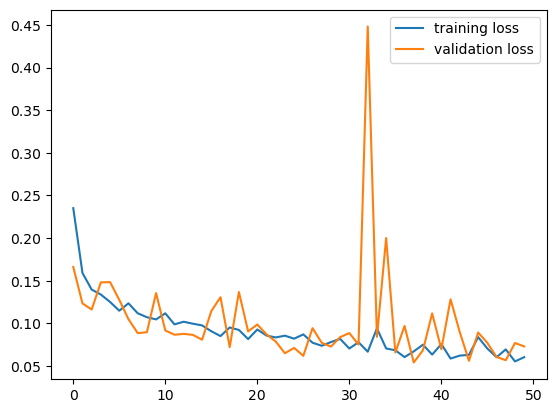

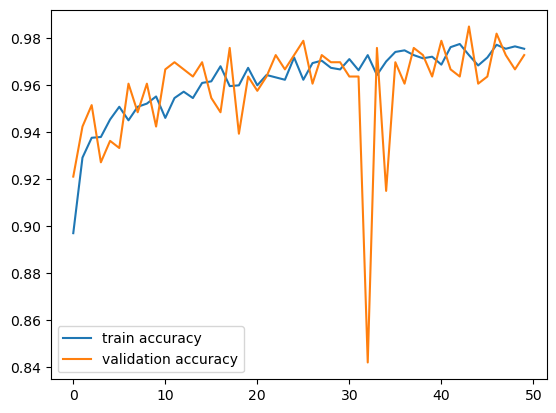

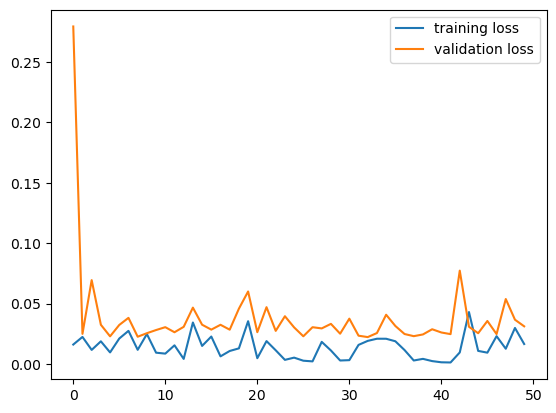

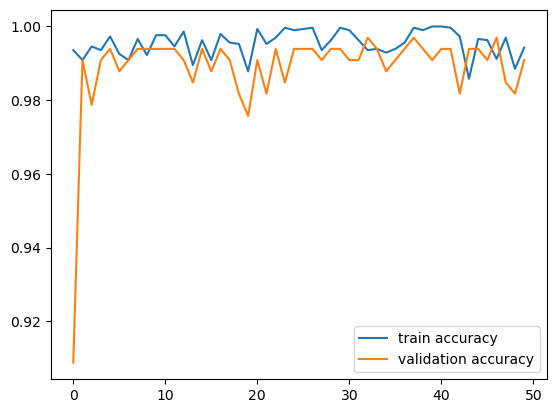

12/12 [==============================] - 0s 2ms/step - loss: 0.0655 - accuracy: 0.9863


loss: 0.06554548442363739 | train acc: 0.9863013625144958


In [319]:
mlp_straightforward = Sequential()
mlp_straightforward.add(Dense(24, activation='tanh', input_dim=spe_tr_d.shape[1]))
mlp_straightforward.add(Dense(8, activation='tanh', input_dim=spe_tr_d.shape[1]))
mlp_straightforward.add(Dense(12, activation='tanh', input_dim=spe_tr_d.shape[1]))
mlp_straightforward.add(Dense(2, activation='softmax'))

mlp_straightforward.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=0.4),  metrics=['accuracy'])

history_straightforward = mlp_straightforward.fit(spe_tr_d, keras.utils.to_categorical(spe_tr_l), epochs=50, validation_split=0.1, verbose=False)

plt.figure()
plt.plot(history_straightforward.history['loss'], label='training loss')
plt.plot(history_straightforward.history['val_loss'], label='validation loss')
plt.legend(loc='best')

plt.figure()
plt.plot(history_straightforward.history['accuracy'], label='train accuracy')
plt.plot(history_straightforward.history['val_accuracy'], label='validation accuracy')
plt.legend(loc='best')

score = mlp_straightforward.evaluate(spe_te_d, keras.utils.to_categorical(spe_te_l))
print("\n\nloss: {} | train acc: {}".format(score[0], score[1]))

history_transfer = mlp_for_transfer.fit(spe_tr_d, keras.utils.to_categorical(spe_tr_l), epochs=50, validation_split=0.1, verbose=False)

plt.figure()
plt.plot(history_transfer.history['loss'], label='training loss')
plt.plot(history_transfer.history['val_loss'], label='validation loss')
plt.legend(loc='best')

plt.figure()
plt.plot(history_transfer.history['accuracy'], label='train accuracy')
plt.plot(history_transfer.history['val_accuracy'], label='validation accuracy')
plt.legend(loc='best')
plt.show()

score = mlp_for_transfer.evaluate(spe_te_d, keras.utils.to_categorical(spe_te_l))
print("\n\nloss: {} | train acc: {}".format(score[0], score[1]))